# Using `neurphys.pacemaking` to make your life easier

In [1]:
# Using the dev version of Neurphys
import sys
sys.path.append('/Users/chadestep/GitHub/surmeierlab/neurphys/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import neurphys as nu

%matplotlib inline
plt.style.use('estep_style')

In [2]:
zero_time = 31.09
df = nu.read_abf.read_abf('/Users/chadestep/Documents/Data/ap_uncaging_2.abf')
df['time'] -= zero_time
df.tail()

/Users/chadestep/anaconda/lib/python3.5/site-packages/neo/io/axonio.py:261: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  nbchannel)).astype('f')


channel_1    primary     time
sweep                                         
sweep005 699995   0.003418 -59.326168  38.9095
         699996   0.003845 -59.631344  38.9096
         699997   0.004150 -58.898922  38.9097
         699998   0.003540 -59.387203  38.9098
         699999   0.004150 -59.204098  38.9099

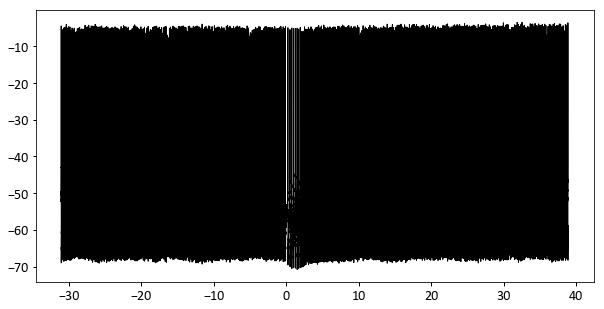

In [3]:
# let's use the fifth sweep since it looks a little cooler
f, ax = plt.subplots()
ax.plot(df['time'].xs('sweep005'),
        df['primary'].xs('sweep005'))

## Find AP peaks with `detect_peaks` function

In [4]:
df_peaks_idx = nu.pacemaking.detect_peaks(df['primary'],mph=-50.1,mpd=200)
df_peaks_idx

array([    739,    2371,    2576, ..., 3497840, 3499354, 3499561])

In [5]:
sweeps = df.index.levels[0]

# can knock out in a single line with a dict comprehension
peaks_dict = {sweep: nu.pacemaking.detect_peaks(df.xs(sweep)['primary'],mph=-20,mpd=200) for sweep in sweeps}
# THIS IS GOING TO BE USED LATER ON FOR THE IEI_ARRAYS FUNCTION

# turn into a dataframe - not necessary, but this is how you'd do it
# df_peaks = pd.DataFrame.from_dict(peaks_dict,orient='index').T
# df_peaks.head()

In [6]:
# create a mask for each sweep
df_masked = {sweep: df.xs(sweep).iloc[peaks_dict[sweep]] for sweep in sweeps}
df_masked['sweep005'].tail()

,channel_1,primary,time
693014,0.004028,-4.455566,38.2114
694408,0.003357,-5.859375,38.3508
696112,0.003906,-4.089355,38.5212
697840,0.004150,-4.333496,38.6940
699561,0.003052,-3.662109,38.8661


(-10, 5)

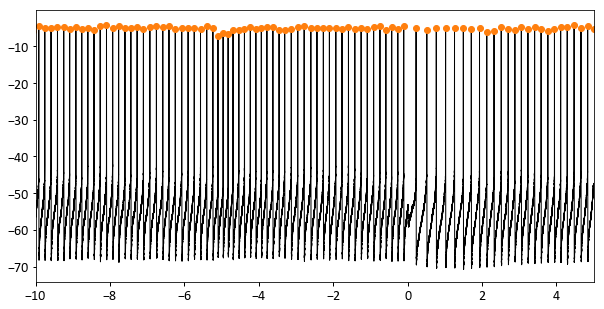

In [7]:
# plot some tests
f, ax = plt.subplots()
ax.plot(df['time'].xs('sweep005'), 
        df['primary'].xs('sweep005'))
ax.plot(df_masked['sweep005']['time'], 
        df_masked['sweep005']['primary'], 
        'o')
ax.set_xlim(-10,5)

## Start analyzing APs with `iei_arrays`

This function is really about producing masking arrays that allow you to pull out relevent data from your original data set. Let's look at an example to get things rolling.



In [8]:
x = np.arange(0.01,1.0,0.01)
percentiles = np.around(x,decimals=2)
percentiles[percentiles == -0] = 0

percent_idxs = nu.pacemaking.iei_arrays(peaks_dict['sweep001'], 
                                        percentiles=percentiles)
# pd.DataFrame.from_dict(percent_idxs)

# Let's go over our current (useful) data structures
---

__df__           : current clamp recording of APs (DataFrame) - made from __`read_abf.read_abf`__

__peaks_dict__   : indicies for APs from df (dict) - made from __`pacemaking.detect_peaks`__

__percent_idxs__ : indicies for AHP percentages, will use to mask df (dict) - made from __`pacemaking.iei_arrays`__

# What else needs to be made to analyze APs?
---

__masked_dict__  : __df__ data masked with __percent_idxs__ arrays (dict)

__means__        : mean for each __masked_dict__ key (1D np.array)

__stds__         : std for each __masked_dict__ key (1D np.array)

In [9]:
masked_dict = {percen: df.xs('sweep001').iloc[percent_idxs[percen]] for percen in percent_idxs.keys()}

In [10]:
means = np.array([masked_dict[percen]['primary'].mean() for percen in percent_idxs.keys()])
stds = np.array([masked_dict[percen]['primary'].std() for percen in percent_idxs.keys()])

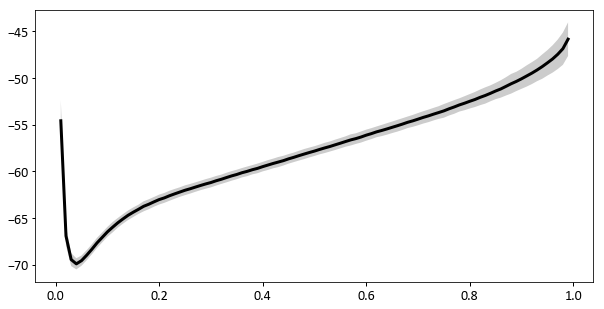

In [11]:
f, ax = plt.subplots()
ax.plot(x, means, linewidth=3)
ax.fill_between(x, means+stds, means-stds, alpha=0.2)

## Also works with negative ranges

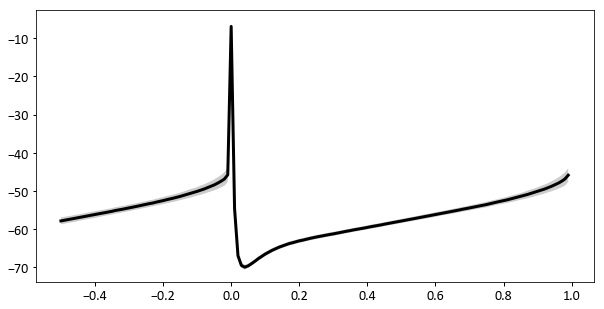

In [12]:
x = np.arange(-0.5,1.0,0.01)
percentiles = np.around(x, decimals=3)
percentiles[percentiles == -0] = 0

percent_idxs = nu.pacemaking.iei_arrays(peaks_dict['sweep001'], 
                                        percentiles=percentiles)

masked_dict = {percen: df.xs('sweep001').iloc[percent_idxs[percen]] for percen in percent_idxs.keys()}
means = np.array([masked_dict[percen]['primary'].mean() for percen in percent_idxs.keys()])
stds  = np.array([masked_dict[percen]['primary'].std() for percen in percent_idxs.keys()])

f, ax = plt.subplots()
ax.plot(x, means, linewidth=3)
ax.fill_between(x, means+stds, means-stds, alpha=0.2)

## And positive and negative shifts

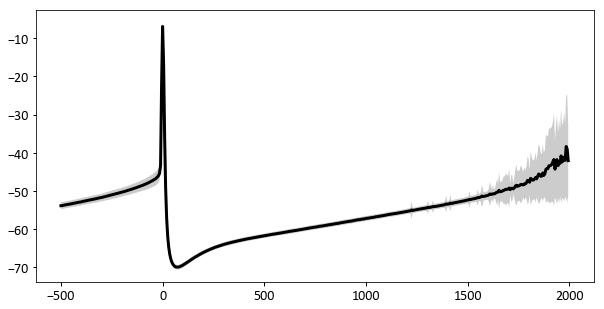

In [13]:
x = np.arange(-500,2000,5)
shifts = np.around(x, decimals=3)
shifts[shifts == -0] = 0

shift_idxs = nu.pacemaking.iei_arrays(peaks_dict['sweep001'], 
                                        shifts=shifts)

masked_dict = {shift: df.xs('sweep001').iloc[shift_idxs[shift]] for shift in shift_idxs.keys()}
means = np.array([masked_dict[shift]['primary'].mean() for shift in shift_idxs.keys()])
stds  = np.array([masked_dict[shift]['primary'].std() for shift in shift_idxs.keys()])

f, ax = plt.subplots()
ax.plot(x, means, linewidth=3)
ax.fill_between(x, means+stds, means-stds, alpha=0.2)

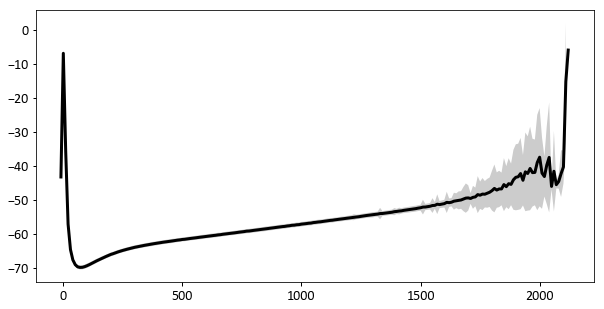

In [15]:
x = np.arange(-10,3000,10)
shifts = np.around(x, decimals=3)
shifts[shifts == -0] = 0

shift_idxs = nu.pacemaking.iei_arrays(peaks_dict['sweep001'], 
                                        shifts=shifts)

masked_dict = {shift: df.xs('sweep001').iloc[shift_idxs[shift]] for shift in shift_idxs.keys()}
means = np.array([masked_dict[shift]['primary'].mean() for shift in shift_idxs.keys()])
stds  = np.array([masked_dict[shift]['primary'].std() for shift in shift_idxs.keys()])

f, ax = plt.subplots()
ax.plot(x, means, linewidth=3)
ax.fill_between(x, means+stds, means-stds, alpha=0.2)